In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import UpSampling2D

from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam

In [2]:
# Load MNIST data
(x_train, _), (_, _) = mnist.load_data()

In [3]:
# Normalize and reshape data
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

In [4]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=5, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(UpSampling2D())
    model.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
    return model

In [5]:
# Define the discriminator
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [6]:
# Define GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [7]:
# Set parameters
img_shape = (28, 28, 1)
z_dim = 100

In [8]:
# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      metrics=['accuracy'])


In [9]:
# Build and compile the generator
generator = build_generator(z_dim)
generator.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

In [10]:
# Build and compile the GAN model
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))


In [11]:
# Training the GAN
epochs     = 2000
batch_size = 64
half_batch = batch_size // 2

In [12]:
# Function to save generated images
def save_generated_images(epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    
    noise = np.random.normal(0, 1, (examples, z_dim))
    
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"./model/gen_images/gan_generated_image_epoch_{epoch}.png")

1/1 [==============================] - 0s 30ms/step


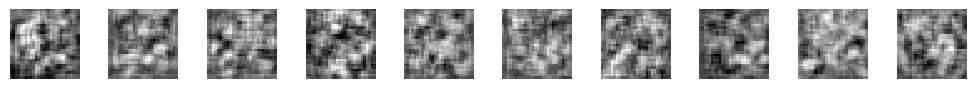

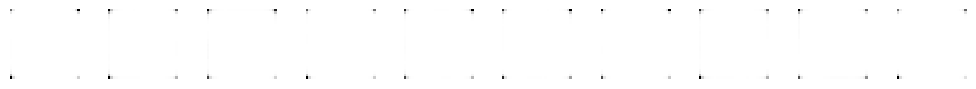

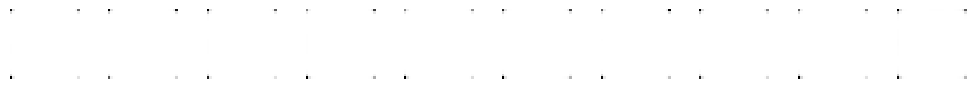

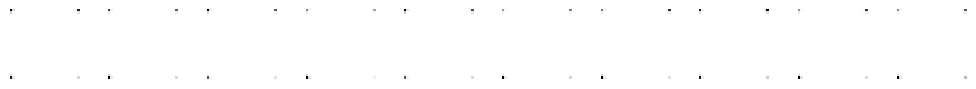

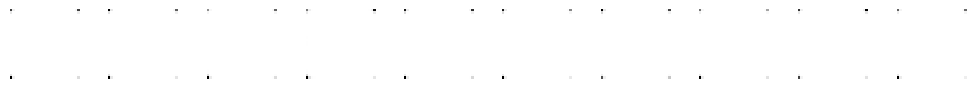

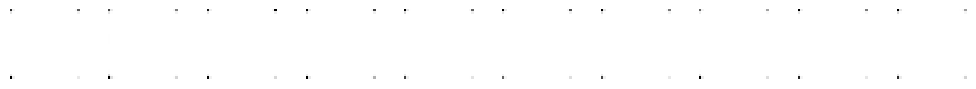

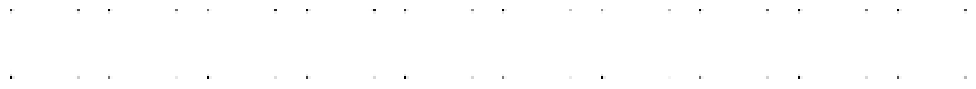

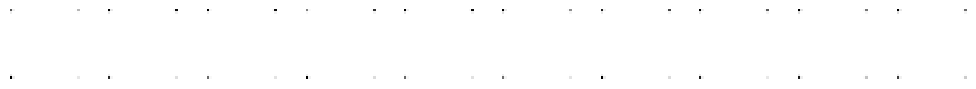

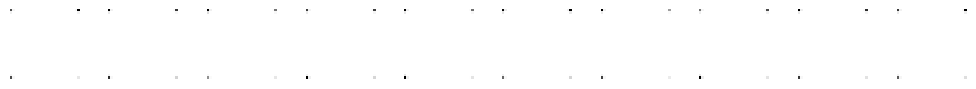

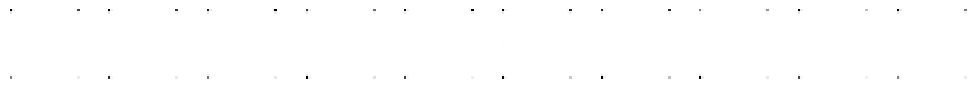

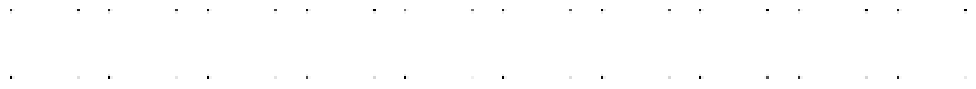

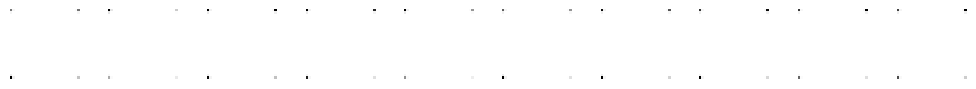

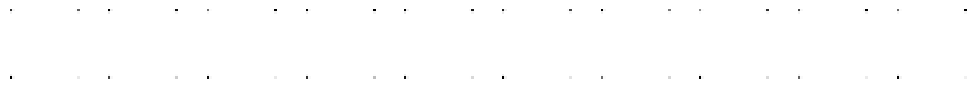

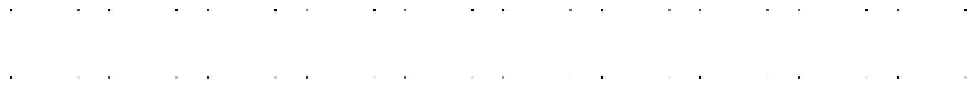

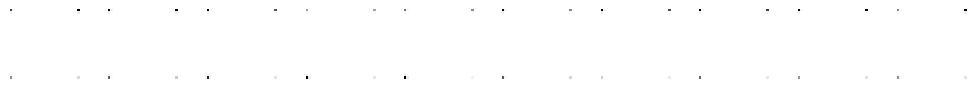

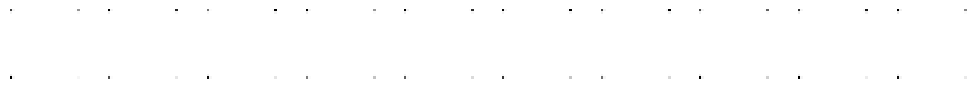

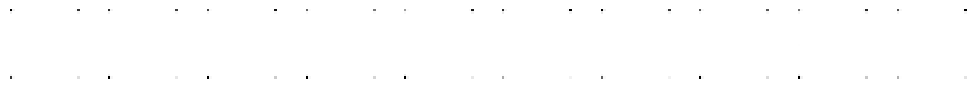

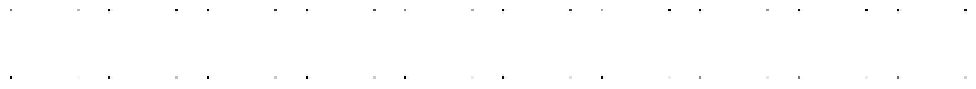

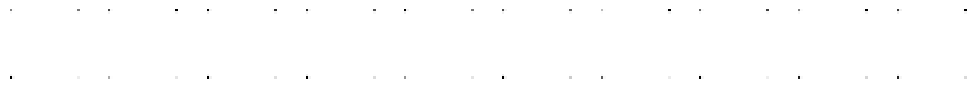

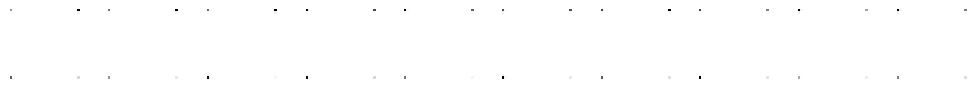

In [13]:
for epoch in range(epochs):
    # Train discriminator
    idx  = np.random.randint(0, x_train.shape[0], half_batch)
    imgs = x_train[idx]
    noise = np.random.normal(0, 1, (half_batch, z_dim))
    gen_imgs = generator.predict(noise, verbose=0 )

    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress
    # if epoch % 100 == 0:
    #     print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

    # Save generated images at specified intervals
    if epoch % 100 == 0:
        save_generated_images(epoch)

In [14]:
# After training
generator.save("./model/generator_model_mnist.h5")

C:\Users\bhupe\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
